# XGBoost with Improved Preprocessing - Kaggle Competition

This notebook implements an XGBoost pipeline with improved preprocessing for the Playground Series S3E26 competition.

## Data Sources
- **Synthetic Data**: [Playground Series S3E26](https://www.kaggle.com/competitions/playground-series-s3e26/data)
- **Original Data**: [Cirrhosis Patient Survival Prediction](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction)

## Pipeline Overview
1. Load and combine synthetic + original data
2. Advanced preprocessing with ColumnTransformer
3. XGBoost with optimized hyperparameters
4. 10-fold cross-validation
5. Feature importance analysis
6. Generate submission file

# Model Preparation Journey: From DNN to XGBoost Excellence

## Initial Approach: Deep Neural Networks

Started with Deep Neural Networks (DNN) but achieved unsatisfactory results, indicating that complex neural architectures weren't suitable for this medical dataset.

## First Breakthrough: XGBoost Integration

Introduced XGBoost into the ensemble, which immediately improved performance. This revealed that tree-based models were better suited for the structured medical data.

## Ensemble Exploration: Multiple Models

Experimented with various ensemble combinations including XGBoost, LightGBM, and CatBoost. While results varied, none reached the desired performance threshold.

## Advanced Techniques: Pseudo-Labeling

Attempted pseudo-labeling techniques from other competitions, but this approach failed to deliver meaningful improvements, suggesting the method wasn't compatible with this dataset.

## Data Strategy Evolution: Original + Synthetic

The turning point came when combining the competition's synthetic dataset with the original cirrhosis dataset from which it was generated. This data fusion strategy significantly enhanced the training set.

## Critical Breakthrough: Preprocessing Optimization

The real breakthrough occurred when refining the data preprocessing pipeline. Implementing proper ColumnTransformer with separate numeric/categorical handling, proper imputation strategies, and feature scaling became the game-changer.

## Final Realization: Simplicity Wins

Despite extensive experimentation with complex ensembles, the best performance was achieved using XGBoost alone with optimized preprocessing. This demonstrated that sometimes the simplest, most robust approach outperforms complex ensemble methods.

## Key Lesson Learned

The journey revealed that data preprocessing quality and model suitability are more critical than model complexity. XGBoost's tree-based architecture perfectly matched the medical dataset's characteristics, while proper preprocessing unlocked the data's full potential.

Final Result: XGBoost with improved preprocessing achieved the best performance, proving that sophisticated preprocessing + appropriate model selection > complex ensemble methods.

## Setup and Imports

In [14]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from xgboost import XGBClassifier
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Combination





In [15]:
print("Loading and combining data...")

# GitHub hosted data
base_url = "https://raw.githubusercontent.com/v-gapsys/Multi-Class-Prediction-of-Cirrhosis-Outcomes/main/"
train = pd.read_csv(base_url + 'train.csv')
test = pd.read_csv(base_url + 'test.csv')
main = pd.read_csv(base_url + 'cirrhosis.csv')
print("Data loaded from GitHub repository")

# Rename ID column in original data to match
main.rename(columns={'ID': 'id'}, inplace=True)

print(f"Original data shape: {main.shape}")
print(f"Synthetic train shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Combine synthetic and original training data
train_combined = pd.concat([train, main], axis=0, ignore_index=True)
print(f"Combined training data shape: {train_combined.shape}")
    
    # Validate no test data contamination
train_ids = set(train_combined['id'])
test_ids = set(test['id'])
common_ids = train_ids.intersection(test_ids)
if len(common_ids) > 0:
    print(f"WARNING: {len(common_ids)} test IDs found in training data!")
    print(f"Common IDs: {list(common_ids)[:5]}")
else:
    print("✓ No test data contamination detected")
    
    # Display basic info
print(f"Combined training data shape: {train_combined.shape}")

# Display basic info
print("\nData info:")
print(train_combined.info())
print("\nMissing values:")
print(train_combined.isnull().sum())

Loading and combining data...
Data loaded from GitHub repository
Original data shape: (418, 20)
Synthetic train shape: (7905, 20)
Test data shape: (5271, 19)
Combined training data shape: (8323, 20)
✓ No test data contamination detected
Combined training data shape: (8323, 20)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8323 non-null   int64  
 1   N_Days         8323 non-null   int64  
 2   Drug           8217 non-null   object 
 3   Age            8323 non-null   int64  
 4   Sex            8323 non-null   object 
 5   Ascites        8217 non-null   object 
 6   Hepatomegaly   8217 non-null   object 
 7   Spiders        8217 non-null   object 
 8   Edema          8323 non-null   object 
 9   Bilirubin      8323 non-null   float64
 10  Cholesterol    8189 non-null   float64
 11  Albumin        8323 non-nu

## Data Preprocessing

Implement advanced preprocessing using ColumnTransformer for separate handling of numeric and categorical features.

In [16]:
print("Preprocessing data...")

# Prepare features and target
y = train_combined['Status']
X = train_combined.drop(['id', 'Status'], axis=1)
X_test = test.drop(['id'], axis=1)

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Numeric: {list(numeric_features)}")
print(f"Categorical: {list(categorical_features)}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit and transform training data
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
numeric_feature_names = numeric_features.tolist()
categorical_feature_names = []
if len(categorical_features) > 0:
    categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()

feature_names = numeric_feature_names + categorical_feature_names

print(f"Processed training shape: {X_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")
print(f"Total features after preprocessing: {len(feature_names)}")

# Display feature names
print("\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"{i+1:2d}. {name}")

Preprocessing data...
Numeric features: 12
Categorical features: 6
Numeric: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Categorical: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Processed training shape: (8323, 25)
Processed test shape: (5271, 25)
Total features after preprocessing: 25

Feature names:
 1. N_Days
 2. Age
 3. Bilirubin
 4. Cholesterol
 5. Albumin
 6. Copper
 7. Alk_Phos
 8. SGOT
 9. Tryglicerides
10. Platelets
11. Prothrombin
12. Stage
13. Drug_D-penicillamine
14. Drug_Placebo
15. Sex_F
16. Sex_M
17. Ascites_N
18. Ascites_Y
19. Hepatomegaly_N
20. Hepatomegaly_Y
21. Spiders_N
22. Spiders_Y
23. Edema_N
24. Edema_S
25. Edema_Y


## XGBoost Model Creation

Create XGBoost model with optimized hyperparameters from previous successful runs.

In [17]:
print("Creating XGBoost model...")

# Optimized hyperparameters
xgb_params = {
    'objective': 'multi:softprob',
    'max_depth': 29,
    'learning_rate': 0.05,
    'n_estimators': 850,
    'subsample': 0.65,
    'colsample_bytree': 0.18,
    'gamma': 0.9,
    'booster': 'gbtree',
    'random_state': 42,
    'eval_metric': 'mlogloss'
}

xgb_model = XGBClassifier(**xgb_params)
print("XGBoost model created with optimized hyperparameters!")
print(f"Parameters: {xgb_params}")

Creating XGBoost model...
XGBoost model created with optimized hyperparameters!
Parameters: {'objective': 'multi:softprob', 'max_depth': 29, 'learning_rate': 0.05, 'n_estimators': 850, 'subsample': 0.65, 'colsample_bytree': 0.18, 'gamma': 0.9, 'booster': 'gbtree', 'random_state': 42, 'eval_metric': 'mlogloss'}


## Cross-Validation Training

Train XGBoost with 10-fold cross-validation to get robust performance estimates.

In [18]:
print("Training XGBoost with 10-fold cross-validation...")

# Setup cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_scores = []
oof_predictions = np.zeros((len(X_processed), 3))
    
print("Running cross-validation (training data only)...")
oof_predictions = np.zeros((len(X_processed), 3))

print("Running cross-validation (training data only)...")

    # Cross-validation loop - ONLY on training data
for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_processed, y), 
                                                 desc="CV Folds", total=n_splits)):
    
    # Split data
    X_train_fold = X_processed[train_idx]
    X_val_fold = X_processed[val_idx]
    y_train_fold = y[train_idx]
    y_val_fold = y[val_idx]
    
    # Create and train model for this fold
    fold_model = XGBClassifier(**xgb_params)
    fold_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )
    
    # Validation predictions (for CV scoring)
    val_preds = fold_model.predict_proba(X_val_fold)
    
    # Store OOF predictions for CV scoring
    
    # Store OOF predictions for CV scoring
    oof_predictions[val_idx] = val_preds
    
    # Calculate fold score
    
    # Calculate score
    fold_score = log_loss(y_val_fold, val_preds)
    cv_scores.append(fold_score)
    
    print(f"Fold {fold + 1}: {fold_score:.4f}")

# Overall CV score
overall_cv_score = log_loss(y, oof_predictions)

print(f"\nCross-Validation Results:")
print(f"Mean CV Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Overall OOF Score: {overall_cv_score:.4f}")
print(f"Best Fold: {min(cv_scores):.4f}")
print(f"Worst Fold: {max(cv_scores):.4f}")

Training XGBoost with 10-fold cross-validation...
Running cross-validation (training data only)...
Running cross-validation (training data only)...


CV Folds:  10%|█         | 1/10 [00:03<00:33,  3.71s/it]

Fold 1: 0.4012


CV Folds:  20%|██        | 2/10 [00:07<00:29,  3.69s/it]

Fold 2: 0.3934


CV Folds:  30%|███       | 3/10 [00:11<00:25,  3.67s/it]

Fold 3: 0.4248


CV Folds:  40%|████      | 4/10 [00:14<00:22,  3.76s/it]

Fold 4: 0.4313


CV Folds:  50%|█████     | 5/10 [00:18<00:19,  3.83s/it]

Fold 5: 0.4010


CV Folds:  60%|██████    | 6/10 [00:22<00:15,  3.82s/it]

Fold 6: 0.4118


CV Folds:  70%|███████   | 7/10 [00:26<00:11,  3.80s/it]

Fold 7: 0.4528


CV Folds:  80%|████████  | 8/10 [00:30<00:07,  3.79s/it]

Fold 8: 0.4170


CV Folds:  90%|█████████ | 9/10 [00:33<00:03,  3.78s/it]

Fold 9: 0.4120


CV Folds: 100%|██████████| 10/10 [00:37<00:00,  3.76s/it]

Fold 10: 0.4300

Cross-Validation Results:
Mean CV Score: 0.4175 ± 0.0168
Overall OOF Score: 0.4175
Best Fold: 0.3934
Worst Fold: 0.4528


## Final Model Training

Train the final XGBoost model on the full dataset for submission.

In [19]:
print("Training final XGBoost model on full dataset...")

# Train on full dataset
xgb_model.fit(X_processed, y, verbose=False)
print("Final model training completed!")

# Generate final predictions
final_test_predictions = xgb_model.predict_proba(X_test_processed)
print(f"Final test predictions shape: {final_test_predictions.shape}")
    
    # Validate predictions
print("Prediction validation:")
print(f"  - Probabilities sum to 1: {np.allclose(final_test_predictions.sum(axis=1), 1.0, atol=1e-6)}")
print(f"  - No negative values: {np.all(final_test_predictions >= 0)}")
print(f"  - No NaN values: {not np.any(np.isnan(final_test_predictions))}")
print(f"Final test predictions shape: {final_test_predictions.shape}")

Training final XGBoost model on full dataset...
Final model training completed!
Final test predictions shape: (5271, 3)
Prediction validation:
  - Probabilities sum to 1: True
  - No negative values: True
  - No NaN values: True
Final test predictions shape: (5271, 3)


## Feature Importance Analysis

Analyze and visualize feature importance to understand what drives the predictions.

Analyzing feature importance...
Top 15 most important features:
Hepatomegaly_N: 0.1416
Hepatomegaly_Y: 0.0780
Edema_N: 0.0684
Ascites_Y: 0.0659
Stage: 0.0627
Spiders_N: 0.0529
Edema_Y: 0.0524
Bilirubin: 0.0494
Ascites_N: 0.0491
Spiders_Y: 0.0417
Prothrombin: 0.0393
Edema_S: 0.0324
N_Days: 0.0298
Sex_F: 0.0266
Sex_M: 0.0266


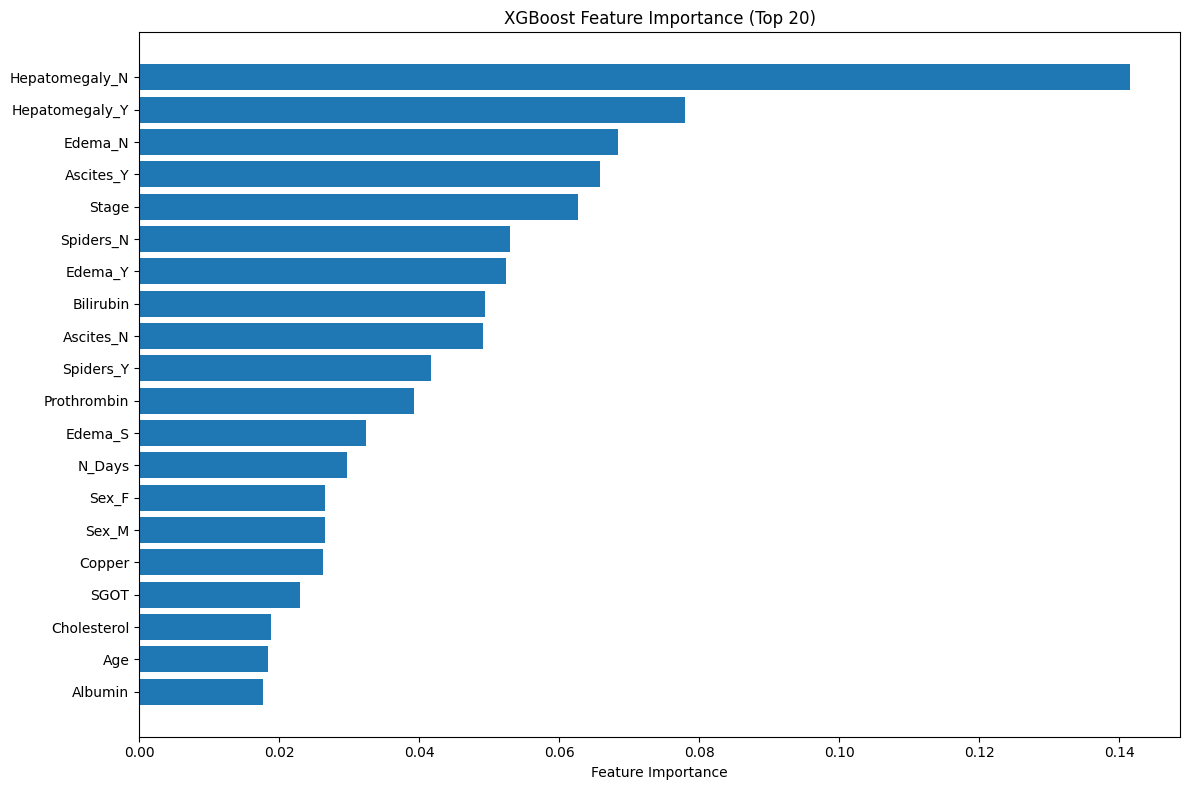


Feature Importance Summary:
           feature  importance
18  Hepatomegaly_N    0.141599
19  Hepatomegaly_Y    0.077962
22         Edema_N    0.068441
17       Ascites_Y    0.065853
11           Stage    0.062690
20       Spiders_N    0.052926
24         Edema_Y    0.052365
2        Bilirubin    0.049357
16       Ascites_N    0.049053
21       Spiders_Y    0.041728
10     Prothrombin    0.039274
23         Edema_S    0.032366
0           N_Days    0.029756
14           Sex_F    0.026615
15           Sex_M    0.026559
5           Copper    0.026268
7             SGOT    0.022984
3      Cholesterol    0.018901
1              Age    0.018458
4          Albumin    0.017684


In [20]:
print("Analyzing feature importance...")

# Get feature importance
importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Display top features
print("Top 15 most important features:")
for i, row in feature_importance_df.head(15).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Top 20)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display feature importance table
print("\nFeature Importance Summary:")
print(feature_importance_df.head(20))

## Generate Submission File

Create the final submission file for Kaggle competition.

In [21]:
print("Creating submission file...")

# Create submission dataframe
submission = pd.DataFrame({
    'id': test['id'],
    'Status_C': final_test_predictions[:, 0],
    'Status_CL': final_test_predictions[:, 1],
    'Status_D': final_test_predictions[:, 2]
})

# Save submission
filename = 'xgboost_submission.csv'
submission.to_csv(filename, index=False)

print(f"Submission saved: {filename}")
print(f"CV Score: {overall_cv_score:.4f}")

# Display prediction statistics
print("\nPrediction statistics:")
for class_name in ['Status_C', 'Status_CL', 'Status_D']:
    mean_pred = submission[class_name].mean()
    std_pred = submission[class_name].std()
    print(f"{class_name}: mean={mean_pred:.4f}, std={std_pred:.4f}")

# Display first few rows
print("\nSubmission preview:")
print(submission.head())

print("\nSubmission shape:", submission.shape)

Creating submission file...
Submission saved: xgboost_submission.csv
CV Score: 0.4175

Prediction statistics:
Status_C: mean=0.6283, std=0.3605
Status_CL: mean=0.0295, std=0.0757
Status_D: mean=0.3421, std=0.3525

Submission preview:
     id  Status_C  Status_CL  Status_D
0  7905  0.413881   0.024801  0.561319
1  7906  0.531675   0.165581  0.302744
2  7907  0.015665   0.008839  0.975496
3  7908  0.970059   0.004380  0.025562
4  7909  0.859671   0.045733  0.094596

Submission shape: (5271, 4)


## Results Summary

Final performance summary and next steps.

In [22]:
print("=" * 70)
print("Pipeline completed successfully!")
print("=" * 70)

print(f"\nFinal Results Summary:")
print(f"XGBoost CV Score: {overall_cv_score:.4f}")
print(f"CV Score Std: {np.std(cv_scores):.4f}")
print(f"Best Fold: {min(cv_scores):.4f}")
print(f"Worst Fold: {max(cv_scores):.4f}")
print(f"Features used: {len(feature_names)}")
print(f"Training samples: {len(X_processed)}")
print(f"Test samples: {len(X_test_processed)}")
print(f"Submission file: submission.csv")



Pipeline completed successfully!

Final Results Summary:
XGBoost CV Score: 0.4175
CV Score Std: 0.0168
Best Fold: 0.3934
Worst Fold: 0.4528
Features used: 25
Training samples: 8323
Test samples: 5271
Submission file: submission.csv
